<a href="https://colab.research.google.com/github/neoyipeng2018/FinancialPhraseBank-v1.0/blob/main/SetFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq datasets
!pip install -Uqq setfit

     |████████████████████████████████| 441 kB 15.2 MB/s 
     |████████████████████████████████| 163 kB 72.9 MB/s 
     |████████████████████████████████| 115 kB 71.1 MB/s 
     |████████████████████████████████| 212 kB 50.8 MB/s 
     |████████████████████████████████| 127 kB 74.5 MB/s 
     |████████████████████████████████| 85 kB 2.9 MB/s 
     |████████████████████████████████| 362 kB 43.0 MB/s 
     |████████████████████████████████| 69 kB 7.3 MB/s 
     |████████████████████████████████| 5.3 MB 52.9 MB/s 
     |████████████████████████████████| 1.3 MB 54.0 MB/s 
     |████████████████████████████████| 7.6 MB 17.9 MB/s 


In [ ]:
import requests
import os
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

In [ ]:
r = requests.get("https://github.com/neoyipeng2018/FinancialPhraseBank-v1.0/raw/main/FinancialPhraseBank-v1.0.zip")
with open('FinancialPhraseBank-v1.0.zip', 'wb') as f: f.write(r.content)
with zipfile.ZipFile('FinancialPhraseBank-v1.0.zip', 'r') as zip_ref: zip_ref.extractall(os.getcwd())

#Research Questions:
1. FinBERT gets 86% accuracy on the financial phrasebank - can SetFit work for finance as well? 

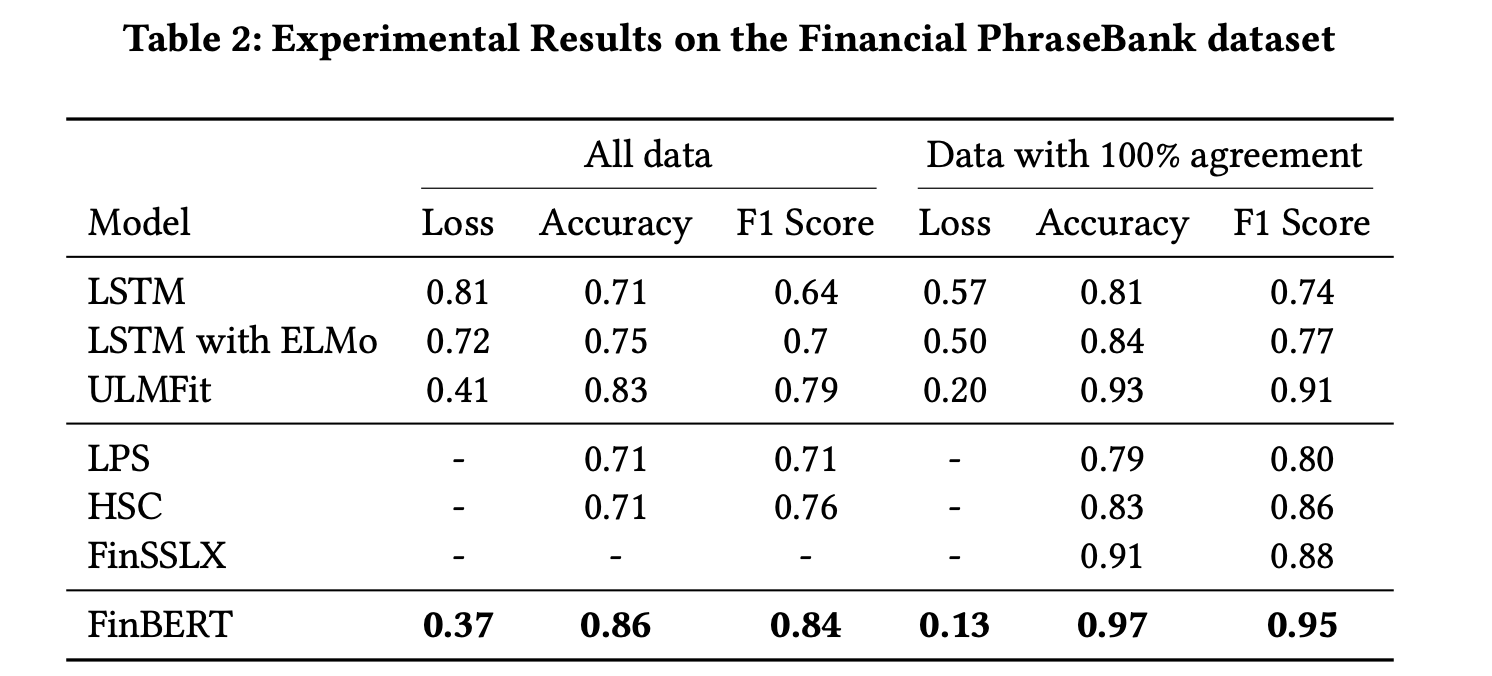

2. There are no FinBERT sentence transformers - would a base MPNet outperform FinBERT

## SetFit on Financial Phrasebank

In [ ]:
Sentences_AllAgree = pd.read_csv('FinancialPhraseBank-v1.0/Sentences_AllAgree.txt',encoding = "ISO-8859-1", names=['text','label'], delimiter= '@')
Sentences_75Agree  = pd.read_csv('FinancialPhraseBank-v1.0/Sentences_75Agree.txt', encoding = "ISO-8859-1", names=['text','label'], delimiter= '@')
Sentences_50Agree  = pd.read_csv('FinancialPhraseBank-v1.0/Sentences_50Agree.txt', encoding = "ISO-8859-1", names=['text','label'], delimiter= '@')
Sentences_66Agree  = pd.read_csv('FinancialPhraseBank-v1.0/Sentences_66Agree.txt', encoding = "ISO-8859-1", names=['text','label'], delimiter= '@')

df = pd.concat([Sentences_AllAgree,Sentences_75Agree,Sentences_50Agree,Sentences_66Agree]).drop_duplicates().reset_index(drop=True)
df.head(2)

,text,label
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive


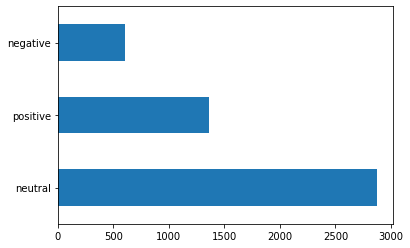

In [ ]:
df['label'].value_counts().plot.barh()

In [ ]:
label_to_int = {'positive':2,'neutral':1,'negative':0}
df.label = df.label.replace(label_to_int)

In [ ]:
from datasets import Dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
from sklearn.model_selection import KFold

Doing 10 fold split as per FinBERT paper

In [ ]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [ ]:
def setfit_train_infer_few_shot(df,shots):
  accuracy = []
  for train_index, test_index in kf.split(df): 
    train_df, test_df = df.loc[train_index], df.loc[test_index]
    
    # tweaked from https://github.com/huggingface/setfit
    num_classes   = 3
    train_dataset = Dataset.from_pandas(train_df).shuffle(seed=42).select(range(shots * num_classes))
    eval_dataset  = Dataset.from_pandas(test_df)

    # Load a SetFit model from Hub
    model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

    # Create trainer
    trainer = SetFitTrainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        loss_class=CosineSimilarityLoss,
        batch_size=16,
        num_iterations=20, # The number of text pairs to generate for contrastive learning
        column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
    )

    # Train and evaluate
    trainer.train()
    acc = trainer.evaluate()['accuracy']
    accuracy.append(acc)
  return sum(accuracy)/len(accuracy)

In [ ]:
shots = [8,16,20,24,30]
setfit   = []

for s in shots: setfit.append(setfit_train_infer_few_shot(df,s))

In [ ]:
setfit

[0.7070247933884298,
 0.7555785123966943,
 0.771694214876033,
 0.7681818181818182,
 0.7880165289256198]

we should also add in a finbert fine tuned on the same amounts of data for a side-by-side comparison

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer

metric = evaluate.load("accuracy")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-pretrain")
def tokenize_function(examples): return tokenizer(examples["text"], padding="max_length", truncation=True,max_length=128)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
def bert_train_infer_few_shot(df,shots):
  accuracy = []
  for train_index, test_index in kf.split(df): 
    train_df, test_df = df.loc[train_index], df.loc[test_index]
    
    # tweaked from https://github.com/huggingface/setfit
    num_classes   = 3
    train_dataset = (Dataset.from_pandas(train_df).shuffle(seed=42).select(range(shots * num_classes))).map(tokenize_function, batched=True)
    eval_dataset  = (Dataset.from_pandas(test_df)).map(tokenize_function, batched=True)

    # Load a SetFit model from Hub
    model = model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-pretrain", num_labels=3)
    training_args = TrainingArguments(output_dir="finbert-finetuned-few-shot")

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
    )

    # Train and evaluate
    trainer.train()
    acc = trainer.evaluate()['eval_accuracy']
    accuracy.append(acc)
  return sum(accuracy)/len(accuracy)

In [ ]:
shots                = [8,16,20,24,30]
finbert_pretrained   = []

for s in shots: finbert_pretrained.append(bert_train_infer_few_shot(df,s))

In [ ]:
finbert_pretrained

[0.6144628099173552,
 0.6444214876033059,
 0.6549586776859504,
 0.6471074380165288,
 0.6694214876033058]

Plotting. pasted values here so i can just run the charts without rerunning the tests.

In [ ]:
shots              = [8,16,20,24,30]
setfit             = [0.7070247933884298,0.7555785123966943,0.771694214876033,0.7681818181818182,0.7880165289256198]
finbert_pretrained = [0.6144628099173552, 0.6444214876033059, 0.6549586776859504, 0.6471074380165288, 0.6694214876033058]
fb                 = [0.86]*5
lstm               = [.71]*5

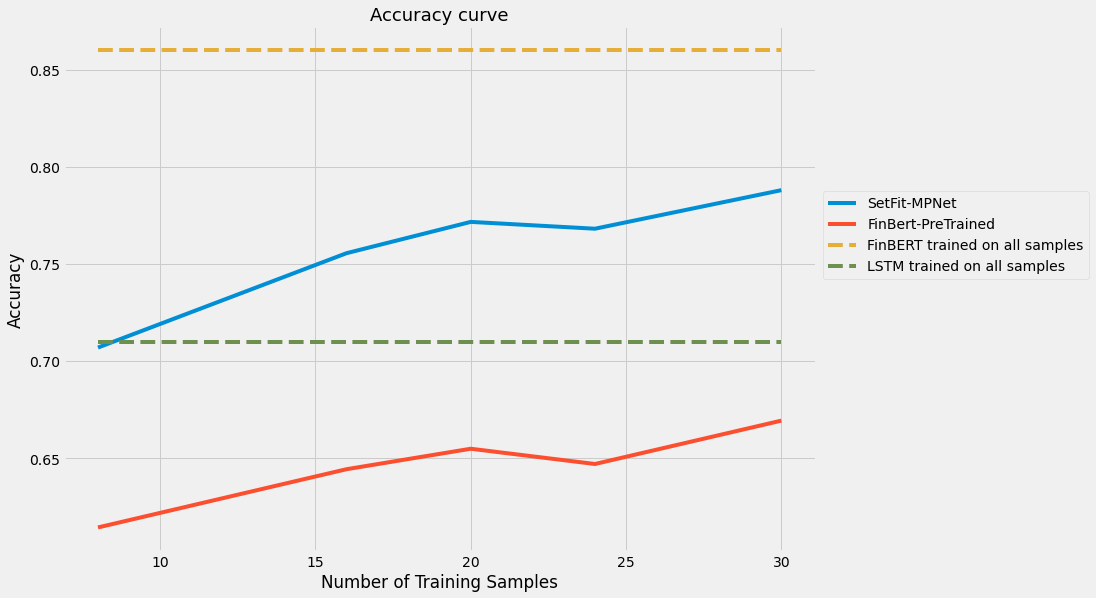

In [ ]:
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots(figsize=(12,9))
ax.set_title('Accuracy curve', fontsize=18)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Training Samples')

pd.DataFrame({'SetFit-MPNet':setfit,
              'FinBert-PreTrained':finbert_pretrained},
             index=shots).plot(ax=ax)

pd.DataFrame({'FinBERT trained on all samples':fb,
              'LSTM trained on all samples':lstm},
             index=shots).plot(ax=ax,linestyle='--')
plt.legend(bbox_to_anchor =(1, 0.7))

## Switching SetFit backbone to finbert?

In [ ]:
def setfit_finbert_train_infer_few_shot(df,shots):
  accuracy = []
  for train_index, test_index in kf.split(df): 
    train_df, test_df = df.loc[train_index], df.loc[test_index]
    
    # tweaked from https://github.com/huggingface/setfit
    num_classes   = 3
    train_dataset = Dataset.from_pandas(train_df).shuffle(seed=42).select(range(shots * num_classes))
    eval_dataset  = Dataset.from_pandas(test_df)

    # Load a SetFit model from Hub
    model = SetFitModel.from_pretrained("yiyanghkust/finbert-pretrain")

    # Create trainer
    trainer = SetFitTrainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        loss_class=CosineSimilarityLoss,
        batch_size=16,
        num_iterations=20, # The number of text pairs to generate for contrastive learning
        column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
    )

    # Train and evaluate
    trainer.train()
    acc = trainer.evaluate()['accuracy']
    accuracy.append(acc)
  return sum(accuracy)/len(accuracy)

In [ ]:
shots = [8,16,20,24,30]
setfit_finbert   = []

for s in shots: setfit_finbert.append(setfit_finbert_train_infer_few_shot(df,s))

In [ ]:
setfit_finbert

[0.6473140495867769,
 0.6621900826446281,
 0.6743801652892562,
 0.6925619834710744,
 0.7301652892561984]

In [ ]:
setfit_finbert     = [0.6473140495867769, 0.6621900826446281, 0.6743801652892562,0.6925619834710744,0.7301652892561984]

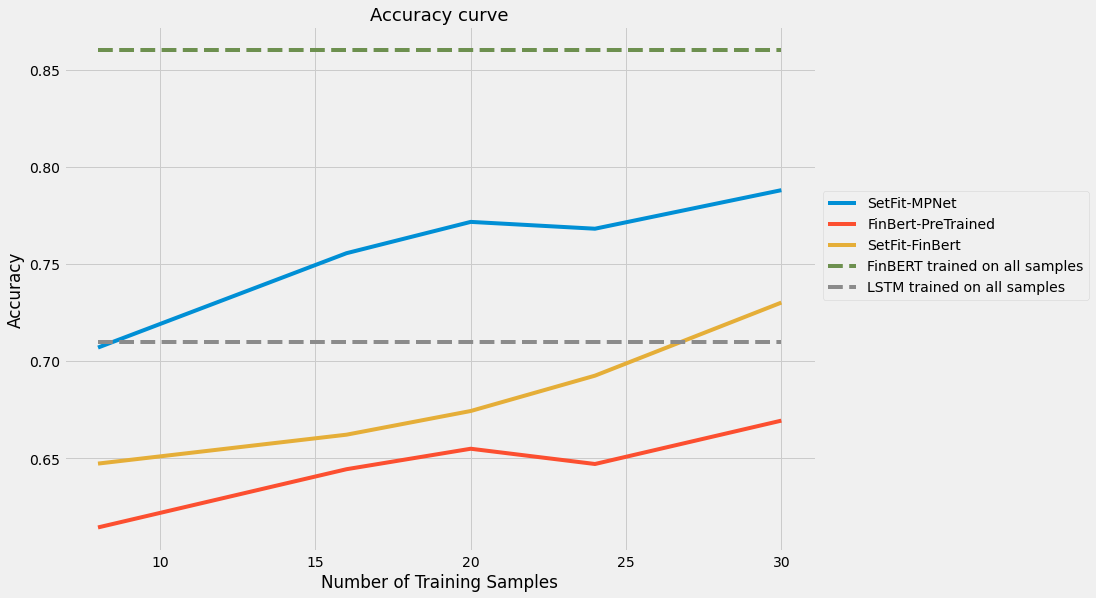

In [ ]:
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots(figsize=(12,9))
ax.set_title('Accuracy curve', fontsize=18)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Training Samples')

pd.DataFrame({'SetFit-MPNet':setfit,
              'FinBert-PreTrained':finbert_pretrained,
              'SetFit-FinBert':setfit_finbert},
             index=shots).plot(ax=ax)

pd.DataFrame({'FinBERT trained on all samples':fb,
              'LSTM trained on all samples':lstm},
             index=shots).plot(ax=ax,linestyle='--')
plt.legend(bbox_to_anchor =(1, 0.7))